# **Ambient Backscatter with Edge AI: Environmental Monitoring Demo**


This notebook implements the entire AmBC pipeline (Ambient RF Source, Tag, Channel, Receiver DSP, AI/ML Training, AI/ML Inference) entirely in Python. This means you do not need GNU Radio or any pre-generated .cfile or .f32 files. The .tflite models will be generated directly by the notebook within your notebook session.

1. Introduction: Safeguarding Health with Battery-Free Environmental Monitoring
Access to clean water and air is fundamental to public health, especially in remote areas where infrastructure is limited. Traditional environmental sensors require constant power and maintenance, which is challenging in many rural settings.

Ambient Backscatter Communication (AmBC) offers a sustainable solution: battery-free sensors that harvest energy by reflecting existing radio signals to send environmental data.

Our project elevates AmBC by integrating Edge AI and Explainable AI (XAI):

Intelligent Data Processing: Tiny AI models (TensorFlow Lite) running on a local hub decode environmental data robustly.

Real-time Anomaly Detection: Identifies unusual environmental patterns (e.g., sudden contamination, pathogen spikes).

Explainable AI (XAI): Provides clear, human-understandable reasons for anomaly alerts to local healthcare workers, empowering them to take informed action.

2. Setting Up Our Simulation Environment
First, we install necessary libraries and set up a folder for our outputs.

In [1]:
# Install necessary libraries if running in a fresh Colab environment
!pip install numpy tensorflow matplotlib scikit-learn scipy

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter # For Python-based DSP filtering

# Ensure a directory for outputs is available
output_directory = "simulation_output"
os.makedirs(output_directory, exist_ok=True)

# Simulation Parameters - These define the 'world' of our digital twin
fs = 1e6  # Sample rate (Hz) - How many data points we take per second
f_carrier = 2.4e9  # Carrier frequency (Hz) - The frequency of the existing radio signal (e.g., Wi-Fi)
duration_seconds = 0.08  # Total simulation time in seconds (increased for more training data)
num_env_readings = 160 # Number of environmental data points (bits) we want to transmit
samples_per_bit_duration = int((fs * duration_seconds) / num_env_readings)

# Recalculate num_env_readings to ensure it matches perfectly with samples_per_bit_duration
num_env_readings = int(fs * duration_seconds) // samples_per_bit_duration

# Time array for plotting
t = np.arange(0, duration_seconds, 1/fs)

# Distances and Signal-to-Noise Ratios (SNR) for realistic channel modeling
distance_source_to_tag_m = 5   # Distance from the RF source to the environmental sensor tag
snr_ambient_db = 30            # Signal quality of the ambient RF
distance_tag_to_receiver_m = 2 # Distance from the environmental sensor tag to our local hub
snr_receiver_db = 15           # Signal quality at our local hub

bit_rate = fs / samples_per_bit_duration # How many bits we're sending per second

print(f"--- Simulation Environment Setup ---")
print(f"  Sampling Rate (fs): {fs / 1e6:.1f} MHz")
print(f"  Carrier Frequency: {f_carrier / 1e9:.1f} GHz")
print(f"  Total Simulation Duration: {duration_seconds * 1000:.1f} ms")
print(f"  Number of Environmental Readings (Bits): {num_env_readings}")
print(f"  Samples Per Reading (Bit): {samples_per_bit_duration}")
print(f"  Effective Data Rate: {bit_rate / 1e3:.1f} kbps")
print("-" * 50)

--- Simulation Environment Setup ---
  Sampling Rate (fs): 1.0 MHz
  Carrier Frequency: 2.4 GHz
  Total Simulation Duration: 80.0 ms
  Number of Environmental Readings (Bits): 160
  Samples Per Reading (Bit): 500
  Effective Data Rate: 2.0 kbps
--------------------------------------------------


3. The Five Core Functional Blocks (Python Implementations)
Our AmBC system simulation is built upon five interconnected functional blocks. We'll define the Python functions for each block.

3.1. Ambient RF Source: Generating the Initial Radio Signal
What it does: This block simulates an existing radio signal in the environment (e.g., a local community Wi-Fi or TV broadcast signal). Our battery-free environmental sensor tag will "borrow" energy from this signal.
Why it's useful: It's the essential power and carrier for any backscatter system. Without an ambient source, the tag has nothing to reflect, ensuring sustainable operation in areas with limited power infrastructure.

In [2]:
def generate_ambient_rf_source(frequency_hz, sample_rate, duration_sec, amplitude=100):
    """Generates a pure sinusoidal ambient RF signal (complex baseband representation)."""
    t = np.arange(0, duration_sec, 1/sample_rate)
    return amplitude * np.exp(1j * 2 * np.pi * frequency_hz * t)

print("Ambient RF Source function defined.")

Ambient RF Source function defined.


3.2. Backscatter Tag: Encoding Environmental Data by Reflecting Signals
What it does: This is the core of backscatter. Our simulated environmental sensor tag collects data (e.g., a 'healthy' or 'contaminated' water reading, or 'low' vs 'high' pathogen presence). It then encodes this data by subtly changing how it reflects the ambient RF signal. For example, a strong reflection might represent 'healthy', a weak reflection 'contaminated'.
Why it's useful: This mechanism allows the tag to send vital environmental data without needing a power-hungry active transmitter, enabling battery-free, continuous monitoring even in remote areas.

In [3]:
def generate_environmental_data(num_samples=100, data_type='water_quality'):
    """Generates synthetic environmental data (e.g., binary 0s/1s for good/bad)."""
    if data_type == 'water_quality':
        # Simulate good (0) and bad (1) water quality readings
        return np.random.randint(0, 2, num_samples)
    elif data_type == 'air_pathogens':
        # Simulate low (0) and high (1) pathogen counts
        return np.random.randint(0, 2, num_samples)
    else:
        raise ValueError("Unsupported data_type. Choose 'water_quality' or 'air_pathogens'.")

def encode_data_ook(sensor_data):
    """Encodes sensor data using On-Off Keying (OOK) - simple binary modulation."""
    # Assuming environmental sensor data is already binary (0s and 1s)
    return sensor_data

def simulate_load_modulation_ook(ambient_rf_signal, encoded_bits, samples_per_bit):
    """Simulates the tag's load modulation, reflecting the ambient signal based on bits."""
    backscattered_signal = np.zeros_like(ambient_rf_signal, dtype=complex)
    total_samples_for_bits = len(encoded_bits) * samples_per_bit

    # Ensure there's enough ambient signal for all bits to be modulated
    if total_samples_for_bits > len(ambient_rf_signal):
        ambient_rf_signal = np.tile(ambient_rf_signal, int(np.ceil(total_samples_for_bits / len(ambient_rf_signal))))[:total_samples_for_bits]

    ambient_rf_signal_modulated_portion = ambient_rf_signal[:total_samples_for_bits]

    for i, bit in enumerate(encoded_bits):
        start_idx = i * samples_per_bit
        end_idx = start_idx + samples_per_bit

        if bit == 1:
            backscattered_signal[start_idx:end_idx] = ambient_rf_signal_modulated_portion[start_idx:end_idx] # Reflect strongly (e.g., 'bad' quality)
        else:
            backscattered_signal[start_idx:end_idx] = ambient_rf_signal_modulated_portion[start_idx:end_idx] * 0.05 # Reflect weakly (e.g., 'good' quality)
    return backscattered_signal

print("Backscatter Tag functions defined (Environmental Data, Encoding, Load Modulation).")

Backscatter Tag functions defined (Environmental Data, Encoding, Load Modulation).


3.3. Communication Channel: Adding Real-World Imperfections
What it does: Real radio signals don't travel perfectly. This block simulates real-world effects like:

Path Loss: Signals get weaker as they travel further from the source.

Additive White Gaussian Noise (AWGN): Random electronic "hiss" that's always present in radio communication, making signals harder to read.
Why it's useful: It makes our simulation realistic. Testing against these impairments ensures our system would work reliably even in challenging rural environments with varying signal conditions.

In [4]:
def add_awgn(signal, snr_db):
    """Adds Additive White Gaussian Noise (AWGN) to a complex signal."""
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10**(snr_db / 10.0)
    noise_power = signal_power / snr_linear if snr_linear > 0 else signal_power / 1e-10
    noise_variance = noise_power / 2.0
    noise_std_dev = np.sqrt(noise_variance)
    noise = noise_std_dev * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise

def apply_path_loss(signal, distance_meters, frequency_hz):
    """Applies basic Free-Space Path Loss (FSPL) to a signal."""
    if distance_meters <= 0 or frequency_hz <= 0:
        print("Warning: Distance or frequency must be positive for path loss. Skipping path loss.")
        return signal

    c = 299792458 # Speed of light
    path_loss_db = 20 * np.log10(distance_meters + 1e-9) + \
                   20 * np.log10(frequency_hz + 1e-9) + \
                   20 * np.log10(4 * np.pi / c)
    attenuation_factor = 10**(-path_loss_db / 20.0)
    return signal * attenuation_factor

print("Communication Channel functions defined (AWGN, Path Loss).")

Communication Channel functions defined (AWGN, Path Loss).


3.4. Receiver DSP (Digital Signal Processing): Extracting the Raw Environmental Data
What it does: This block mimics what a local Software-Defined Radio (SDR) hub would do. It takes the noisy, reflected environmental signal and processes it to make the data readable. This involves:

Complex to Magnitude: Converting the complex radio signal into its amplitude, revealing the 'good'/'bad' changes.

Low-pass Filtering: Smoothing out the signal and removing high-frequency noise, leaving just our baseband environmental data.
Why it's useful: It transforms the raw radio waves into a clean, digital-like signal that can be understood by computers and our AI models, bridging the gap between RF and data.

In [5]:
def receiver_dsp_python(received_signal_complex, fs, bit_rate):
    """
    Performs basic receiver DSP in Python: Complex to Magnitude -> Low-pass filter.
    """
    # 1. Complex to Magnitude (Envelope Detection)
    demodulated_signal_mag = np.abs(received_signal_complex)

    # 2. Low-pass filter to smooth the envelope and extract baseband signal
    nyquist = 0.5 * fs # Nyquist frequency
    cutoff_freq_norm = (bit_rate * 1.5) / nyquist # Cutoff at 1.5 times the bit rate
    if cutoff_freq_norm >= 1.0: # Ensure cutoff is less than Nyquist
        cutoff_freq_norm = 0.99

    order = 5 # Filter order
    # Design the Butterworth low-pass filter
    b, a = butter(order, cutoff_freq_norm, btype='low', analog=False)
    # Apply the filter
    filtered_baseband_signal = lfilter(b, a, demodulated_signal_mag)

    return filtered_baseband_signal

print("Receiver DSP function defined (Python-based Complex to Magnitude and Low-pass Filter).")

Receiver DSP function defined (Python-based Complex to Magnitude and Low-pass Filter).


3.5. Edge AI (TensorFlow Lite) with Explainable AI: Intelligent Analysis & Justification
What it does: This is the "brain" of our environmental monitoring system. We train two small neural networks and convert them to TensorFlow Lite (TFLite), making them tiny enough for edge devices (e.g., a Raspberry Pi Zero W in a remote clinic):

Environmental Data Classifier Model: Learns to distinguish between 'good' (0) and 'bad' (1) environmental readings in noisy signals.

Anomaly Detection Model: Learns what "normal" environmental patterns look like. If it sees something unusual (e.g., a sudden spike in pathogen levels, an unexpected change in water quality), it flags it as an "anomaly."
Explainable AI (XAI) Component: When an anomaly is detected, this component provides a simple, human-understandable reason. Instead of just "Anomaly Detected," it will offer insights like "Anomaly due to unusually high average signal" or "Anomaly due to sudden sharp spike in readings."
Why it's useful: This makes our AmBC system truly smart and actionable. It can reliably classify environmental data in challenging conditions and proactively alert local healthcare workers to potential issues, providing crucial context for rapid intervention.

In [10]:
# --- ML Training Data Preparation ---
def inject_anomalies(signal_segments, anomaly_ratio=0.1, anomaly_type='amplitude_shift', noise_factor=5.0):
    """Artificially injects anomalies into signal segments for training the anomaly detector."""
    num_anomalies = int(len(signal_segments) * anomaly_ratio)
    anomaly_indices = np.random.choice(len(signal_segments), num_anomalies, replace=False)

    anomalous_segments = np.copy(signal_segments)
    anomaly_labels = np.zeros(len(signal_segments), dtype=int)

    for idx in anomaly_indices:
        segment = anomalous_segments[idx]
        if anomaly_type == 'amplitude_shift':
            anomalous_segments[idx] = segment * np.random.uniform(0.01, 0.2) if np.random.rand() < 0.5 else segment * np.random.uniform(3.0, 8.0)
        elif anomaly_type == 'noise_burst':
            anomalous_segments[idx] = segment + np.random.randn(*segment.shape) * np.std(segment) * noise_factor
        elif anomaly_type == 'zero_out':
            anomalous_segments[idx] = np.zeros_like(segment)
        else:
            raise ValueError("Invalid anomaly_type.")

        anomaly_labels[idx] = 1

    return anomalous_segments, anomaly_labels

# --- Keras Model Definition and Training ---
def create_and_train_keras_model(X_train, y_train, X_val, y_val, samples_per_bit, model_type='classifier', epochs=15, batch_size=32):
    """Creates, compiles, trains, and evaluates a small Keras model."""
    print(f"\n--- Training Keras Model ({model_type}) (Input Shape: {samples_per_bit}) ---")

    # Normalize input data (crucial for neural networks)
    mean = np.mean(X_train)
    std = np.std(X_train) + 1e-8
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std

    model = keras.Sequential([
        keras.layers.Input(shape=(samples_per_bit,)), # Input layer size matches our signal segment length
        keras.layers.Dense(64, activation='relu'),    # Hidden layer with ReLU activation
        keras.layers.Dropout(0.3 if model_type == 'anomaly_detector' else 0.2), # Prevents overfitting
        keras.layers.Dense(32, activation='relu'),    # Another hidden layer
        keras.layers.Dense(1, activation='sigmoid')   # Output layer for binary classification (0 or 1)
    ])

    model.compile(optimizer='adam',                  # Optimization algorithm
                  loss='binary_crossentropy',        # Loss function for binary classification
                  metrics=['accuracy'])              # Metric to monitor during training

    model.summary()

    history = model.fit(X_train_norm, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_norm, y_val),
                        verbose=0) # Set to 0 for less verbose output in notebook, 1 for progress

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type.replace("_", " ").title()} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_type.replace("_", " ").title()} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, mean, std # Return normalization parameters for inference

# --- TensorFlow Lite Conversion ---
def convert_to_tflite(keras_model, tflite_model_path, model_name=""):
    """Converts a trained Keras model to a lightweight TensorFlow Lite format."""
    print(f"\n--- Converting Keras Model ({model_name}) to TensorFlow Lite ---")
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply default optimizations for smaller size/faster inference
    tflite_model = converter.convert()

    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print(f"TensorFlow Lite {model_name} model saved to: {tflite_model_path}")

# --- TFLite Inference Functions ---
def decode_with_tflite_env_classifier(interpreter, input_details, output_details, segment_norm):
    """Classifies a single signal segment using the TFLite environmental data classifier model."""
    input_data = np.array([segment_norm], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke() # Run the inference
    output_data = interpreter.get_tensor(output_details[0]['index'])
    confidence = output_data[0][0]
    # Assuming 0: Good/Low, 1: Bad/High
    predicted_class = 1 if confidence > 0.5 else 0
    return predicted_class, confidence

def predict_anomaly_with_tflite(interpreter, input_details, output_details, segment_norm):
    """Predicts anomaly for a single signal segment using the TFLite anomaly detector."""
    input_data = np.array([segment_norm], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke() # Run the inference
    output_data = interpreter.get_tensor(output_details[0]['index'])
    anomaly_score = output_data[0][0]
    is_anomaly = True if anomaly_score > 0.5 else False # Threshold to decide if it's an anomaly
    return is_anomaly, anomaly_score

# --- Explainable AI (XAI) Component ---
def explain_anomaly(anomalous_segment, normal_data_mean, normal_data_std, threshold_factor=2.0):
    """
    Provides a simple explanation for an anomaly based on segment characteristics.
    Compares the anomalous segment's properties to the 'normal' training data.
    """
    segment_mean = np.mean(anomalous_segment)
    segment_std = np.std(anomalous_segment)

    explanation = []

    # Check if average value is significantly different from normal
    if segment_mean > normal_data_mean + threshold_factor * normal_data_std:
        explanation.append("unusually high average reading")
    elif segment_mean < normal_data_mean - threshold_factor * normal_data_std:
        explanation.append("unusually low average reading")

    # Check if variability is significantly higher than normal
    if segment_std > normal_data_std * threshold_factor:
        explanation.append("very high variability/noise")
    elif segment_std < normal_data_std / threshold_factor:
        explanation.append("unusually low variability (stuck sensor?)") # Could indicate sensor issue

    if not explanation:
        explanation.append("unusual pattern detected (subtle deviation)") # General catch-all

    return "Anomaly due to: " + ", ".join(explanation) + "."

# --- Metrics Calculation ---
def calculate_accuracy(original_classes, predicted_classes):
    """Calculates the accuracy for environmental data classification."""
    if len(original_classes) != len(predicted_classes):
        min_len = min(len(original_classes), len(predicted_classes))
        original_classes = original_classes[:min_len]
        predicted_classes = predicted_classes[:min_len]

    correct = np.sum(original_classes == predicted_classes)
    total = len(original_classes)
    if total == 0:
        return 0.0
    return correct / total

print("Edge AI (TFLite) and Explainable AI (XAI) functions defined.")

Edge AI (TFLite) and Explainable AI (XAI) functions defined.


4. Executing the End-to-End AmBC Simulation (Python-Only)
Now, let's run our digital twin pipeline step-by-step and visualize the signals at each stage!

1. Ambient RF Source generated (length: 80000 samples)
2. Ambient RF Signal at Tag (after 5m path loss, 30dB SNR)
3. Environmental Data Generated & Encoded (OOK): [0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1
 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1
 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0
 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1
 0 0 1 1 1 0 1 1 0 1 0 0]
4. Backscattered Signal from Tag generated (length: 80000 samples)
5. Final Received Signal at Local Hub Receiver (after 2m path loss, 15dB SNR)
6. Demodulated Baseband Signal generated (length: 80000 samples)
--------------------------------------------------


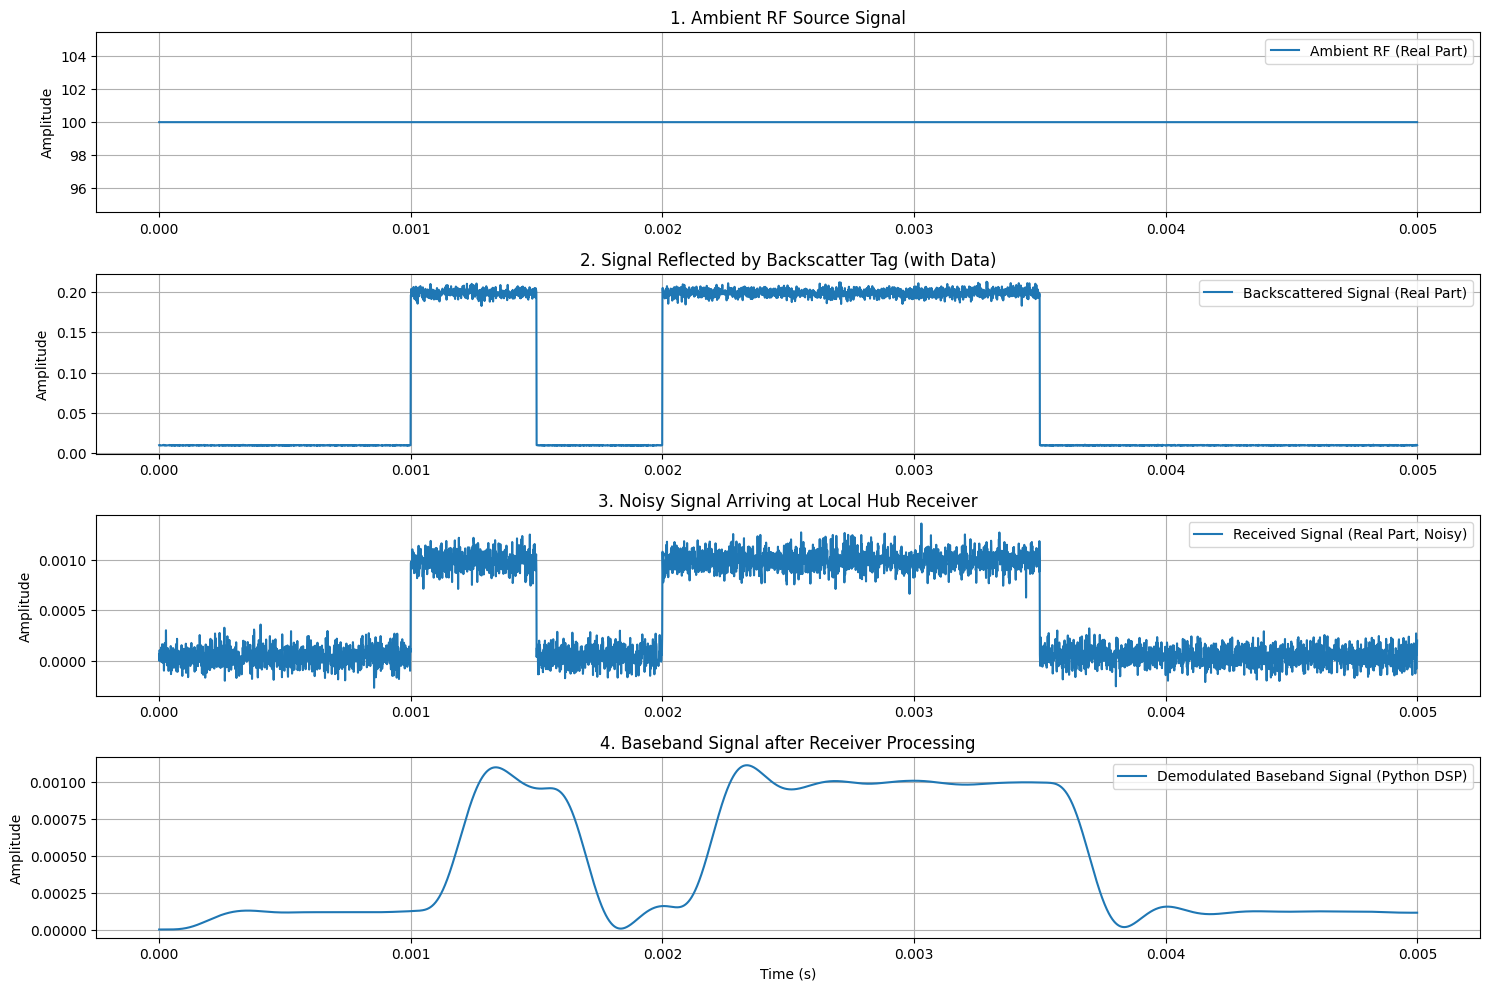

In [7]:
# --- Step 1: Generate Ambient RF Source ---
# Our "Wi-Fi signal" that the tag will use
ambient_rf_signal_base = generate_ambient_rf_source(f_carrier, fs, duration_seconds)
print(f"1. Ambient RF Source generated (length: {len(ambient_rf_signal_base)} samples)")

# --- Step 2: Simulate Communication Channel: Ambient Source to Tag ---
# Signal travels from Wi-Fi source to our battery-free tag
ambient_rf_signal_at_tag = apply_path_loss(ambient_rf_signal_base, distance_source_to_tag_m, f_carrier)
ambient_rf_signal_at_tag = add_awgn(ambient_rf_signal_at_tag, snr_ambient_db)
print(f"2. Ambient RF Signal at Tag (after {distance_source_to_tag_m}m path loss, {snr_ambient_db}dB SNR)")

# --- Step 3: Environmental Data Generation & Encoding ---
# The tag reads environmental data (e.g., water quality: 0=good, 1=bad)
original_env_data = generate_environmental_data(num_env_readings, data_type='water_quality')
original_encoded_bits = encode_data_ook(original_env_data) # OOK encoding
print(f"3. Environmental Data Generated & Encoded (OOK): {original_encoded_bits}")

# --- Step 4: Load Modulation Logic (Simulated Backscatter Tag) ---
# The tag modulates its data by reflecting the ambient signal differently
backscattered_signal_from_tag = simulate_load_modulation_ook(
    ambient_rf_signal_at_tag, original_encoded_bits, samples_per_bit=samples_per_bit_duration
)
print(f"4. Backscattered Signal from Tag generated (length: {len(backscattered_signal_from_tag)} samples)")

# --- Step 5: Simulate Communication Channel: Tag to Local Hub Receiver ---
# The modulated signal travels from the tag to our local data processing hub
received_signal_at_receiver = apply_path_loss(
    backscattered_signal_from_tag, distance_tag_to_receiver_m, f_carrier
)
final_received_signal_noisy = add_awgn(received_signal_at_receiver, snr_receiver_db)
print(f"5. Final Received Signal at Local Hub Receiver (after {distance_tag_to_receiver_m}m path loss, {snr_receiver_db}dB SNR)")

# --- Step 6: Receiver DSP (Digital Signal Processing in Python) ---
# Our local hub processes the noisy RF signal to get usable data
demodulated_signal = receiver_dsp_python(final_received_signal_noisy, fs, bit_rate)
print(f"6. Demodulated Baseband Signal generated (length: {len(demodulated_signal)} samples)")

print("-" * 50)

# --- Visualize the Signals at Different Stages ---
plt.figure(figsize=(15, 12))
max_plot_points = 5000 # Limit points for faster plotting and clarity

# Plot 1: Ambient RF Signal (at source)
plt.subplot(5, 1, 1)
plt.plot(t[:max_plot_points], ambient_rf_signal_base.real[:max_plot_points], label='Ambient RF (Real Part)')
plt.title('1. Ambient RF Source Signal')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot 2: Backscattered Signal from Tag (modulated)
plt.subplot(5, 1, 2)
plt.plot(t[:max_plot_points], backscattered_signal_from_tag.real[:max_plot_points], label='Backscattered Signal (Real Part)')
plt.title('2. Signal Reflected by Backscatter Tag (with Data)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot 3: Final Received Signal (at receiver, with noise)
plt.subplot(5, 1, 3)
plt.plot(t[:max_plot_points], final_received_signal_noisy.real[:max_plot_points], label='Received Signal (Real Part, Noisy)')
plt.title('3. Noisy Signal Arriving at Local Hub Receiver')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot 4: Demodulated Baseband Signal (after Python DSP)
plt.subplot(5, 1, 4)
plt.plot(t[:max_plot_points], demodulated_signal[:max_plot_points], label='Demodulated Baseband Signal (Python DSP)')
plt.title('4. Baseband Signal after Receiver Processing')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

5. Training Our Edge AI Models (Classifier & Anomaly Detector)
Now we use the processed signal to train our compact neural networks for intelligent environmental data classification and anomaly detection. These models will be converted to TFLite for deployment on low-cost edge computing hubs in remote clinics.


Prepared 160 signal segments for ML training.

--- Starting Environmental Data Classifier Model Training ---

--- Training Keras Model (Environmental Data Classifier) (Input Shape: 500) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,177 (133.50 KB)

 Trainable params: 34,177 (133.50 KB)

 Non-trainable params: 0 (0.00 B)

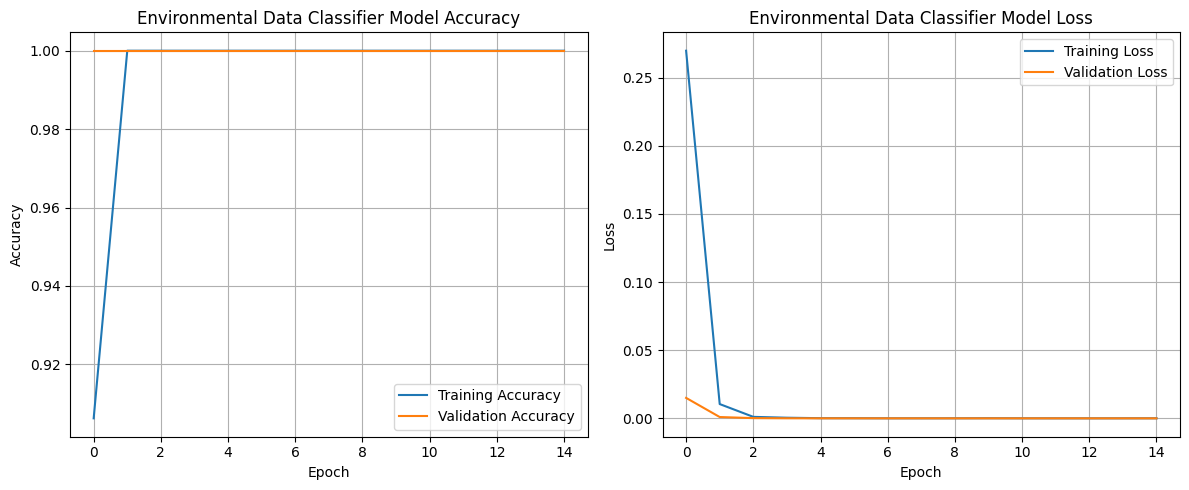


--- Converting Keras Model (Environmental Data Classifier) to TensorFlow Lite ---
Saved artifact at '/tmp/tmp4pc7xkp7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 500), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132630039133264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630039133648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630039134032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036727760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036728336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036729104: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite Environmental Data Classifier model saved to: simulation_output/env_data_classifier.tflite

--- Starting Anomaly Detection Model Training ---

--- Training Keras Model (Anomaly Detector) (Input Shape: 500)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,177 (133.50 KB)

 Trainable params: 34,177 (133.50 KB)

 Non-trainable params: 0 (0.00 B)

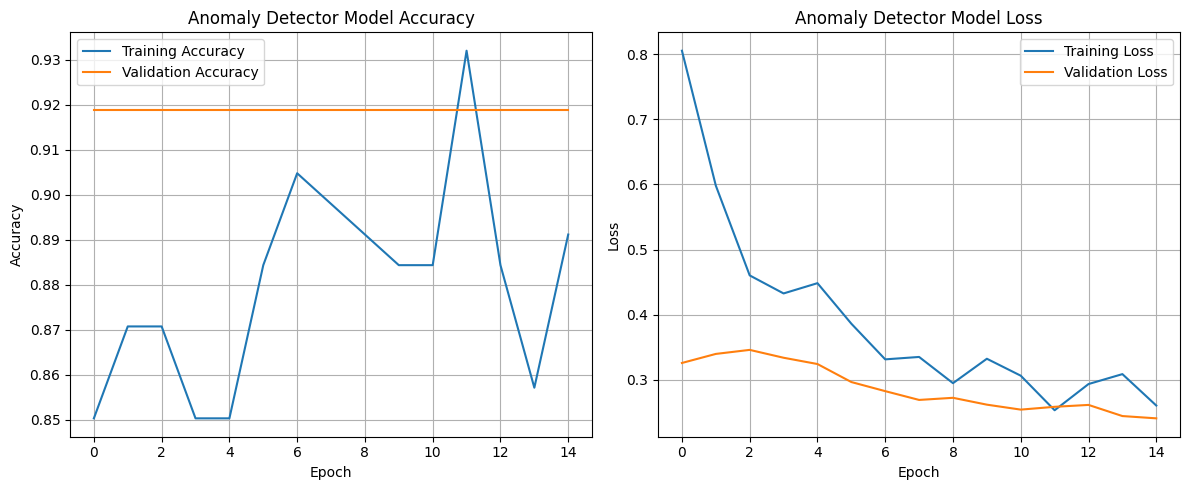


--- Converting Keras Model (Anomaly Detector) to TensorFlow Lite ---
Saved artifact at '/tmp/tmpqge2a6qe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 500), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132630036731984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036733328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036737936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036735632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036733904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132630036738320: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite Anomaly Detector model saved to: simulation_output/anomaly_detector.tflite


In [8]:
# --- Prepare Data for ML Model Training ---
signal_segments = []
num_segments_in_signal = len(demodulated_signal) // samples_per_bit_duration
if num_segments_in_signal == 0:
    print("Error: Demodulated signal too short for ML training. Increase simulation duration.")
else:
    for i in range(num_segments_in_signal):
        start_idx = i * samples_per_bit_duration
        end_idx = start_idx + samples_per_bit_duration
        segment = demodulated_signal[start_idx:end_idx]
        if len(segment) == samples_per_bit_duration: # Ensure segment is full length
            signal_segments.append(segment)
    signal_segments = np.array(signal_segments).astype(np.float32)

    num_segments = len(signal_segments)
    # Ensure original_encoded_bits matches the number of signal segments
    y_true_classes = original_encoded_bits[:num_segments].astype(np.float32)

    print(f"\nPrepared {num_segments} signal segments for ML training.")

    # --- Step 7: Train and Convert Environmental Data Classifier Model ---
    print("\n--- Starting Environmental Data Classifier Model Training ---")
    X_train_env, X_val_env, y_train_env, y_val_env = train_test_split(
        signal_segments, y_true_classes, test_size=0.2, random_state=42,
        stratify=y_true_classes if len(np.unique(y_true_classes)) > 1 else None # Stratify only if both classes are present
    )
    trained_env_model, env_model_mean, env_model_std = create_and_train_keras_model(
        X_train_env, y_train_env, X_val_env, y_val_env, samples_per_bit_duration, model_type='Environmental Data Classifier'
    )
    tflite_env_classifier_path = os.path.join(output_directory, "env_data_classifier.tflite")
    convert_to_tflite(trained_env_model, tflite_env_classifier_path, model_name="Environmental Data Classifier")

    # --- Step 8: Train and Convert Anomaly Detection Model ---
    print("\n--- Starting Anomaly Detection Model Training ---")
    # We inject some artificial anomalies for training purposes (e.g., simulating sudden contamination)
    anomalous_segments_spike, anomaly_labels_spike = inject_anomalies(
        signal_segments, anomaly_ratio=0.05, anomaly_type='amplitude_shift', noise_factor=15.0 # Use higher factor for distinct anomalies
    )
    anomalous_segments_drop, anomaly_labels_drop = inject_anomalies(
        signal_segments, anomaly_ratio=0.05, anomaly_type='amplitude_shift', noise_factor=0.1 # Simulate drops
    )
    anomalous_segments_noisy, anomaly_labels_noisy = inject_anomalies(
        signal_segments, anomaly_ratio=0.05, anomaly_type='noise_burst', noise_factor=10.0
    )

    # Combine normal and anomalous data for anomaly detector training
    true_anomalous_spike = anomalous_segments_spike[anomaly_labels_spike == 1]
    true_anomalous_drop = anomalous_segments_drop[anomaly_labels_drop == 1]
    true_anomalous_noisy = anomalous_segments_noisy[anomaly_labels_noisy == 1]

    X_anomaly = np.concatenate((signal_segments, true_anomalous_spike, true_anomalous_drop, true_anomalous_noisy), axis=0)
    y_anomaly = np.concatenate((np.zeros(len(signal_segments), dtype=np.float32), # Normal segments are 0
                                np.ones(len(true_anomalous_spike), dtype=np.float32), # Injected anomalies are 1
                                np.ones(len(true_anomalous_drop), dtype=np.float32),
                                np.ones(len(true_anomalous_noisy), dtype=np.float32)), axis=0)

    X_anomaly, y_anomaly = shuffle(X_anomaly, y_anomaly, random_state=42) # Shuffle data for training

    X_train_anomaly, X_val_anomaly, y_train_anomaly, y_val_anomaly = train_test_split(
        X_anomaly, y_anomaly, test_size=0.2, random_state=42,
        stratify=y_anomaly if len(np.unique(y_anomaly)) > 1 else None
    )

    trained_anomaly_model, anomaly_model_mean, anomaly_model_std = create_and_train_keras_model(
        X_train_anomaly, y_train_anomaly, X_val_anomaly, y_val_anomaly, samples_per_bit_duration, model_type='Anomaly Detector'
    )
    tflite_anomaly_detector_path = os.path.join(output_directory, "anomaly_detector.tflite")
    convert_to_tflite(trained_anomaly_model, tflite_anomaly_detector_path, model_name="Anomaly Detector")

6. Performing Edge AI Inference and Verification with Explainable AI
Finally, we load our trained TFLite models and apply them to the simulated signal. We'll classify the environmental data, detect anomalies, and for each anomaly, provide a human-understandable explanation.


--- Starting TFLite Inference ---
Environmental data classifier model 'simulation_output/env_data_classifier.tflite' loaded for inference.
Anomaly detector model 'simulation_output/anomaly_detector.tflite' loaded for inference.

Processing 160 signal segments with Edge AI models...

Predicted Environmental Classes (TFLite): ['Good Env.', 'Good Env.', 'Bad Env.', 'Good Env.', 'Bad Env.', 'Bad Env.', 'Bad Env.', 'Good Env.', 'Good Env.', 'Good Env.', 'Good Env.', 'Good Env.', 'Bad Env.', 'Good Env.', 'Bad Env.', 'Good Env.', 'Bad Env.', 'Bad Env.', 'Bad Env.', 'Bad Env.']...
Confidences: [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.]...
Anomaly Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]...
Anomaly Scores: [0.25 0.22 0.03 0.02 0.03 0.15 0.15 0.02 0.22 0.22 0.22 0.22 0.03 0.02
 0.03 0.02 0.03 0.15 0.16 0.16]...
Anomaly Explanations (first 5 anomalies):

--- Results ---
Environmental Data Classification Accuracy (TFLite Model): 1.0000
Classification Verification:

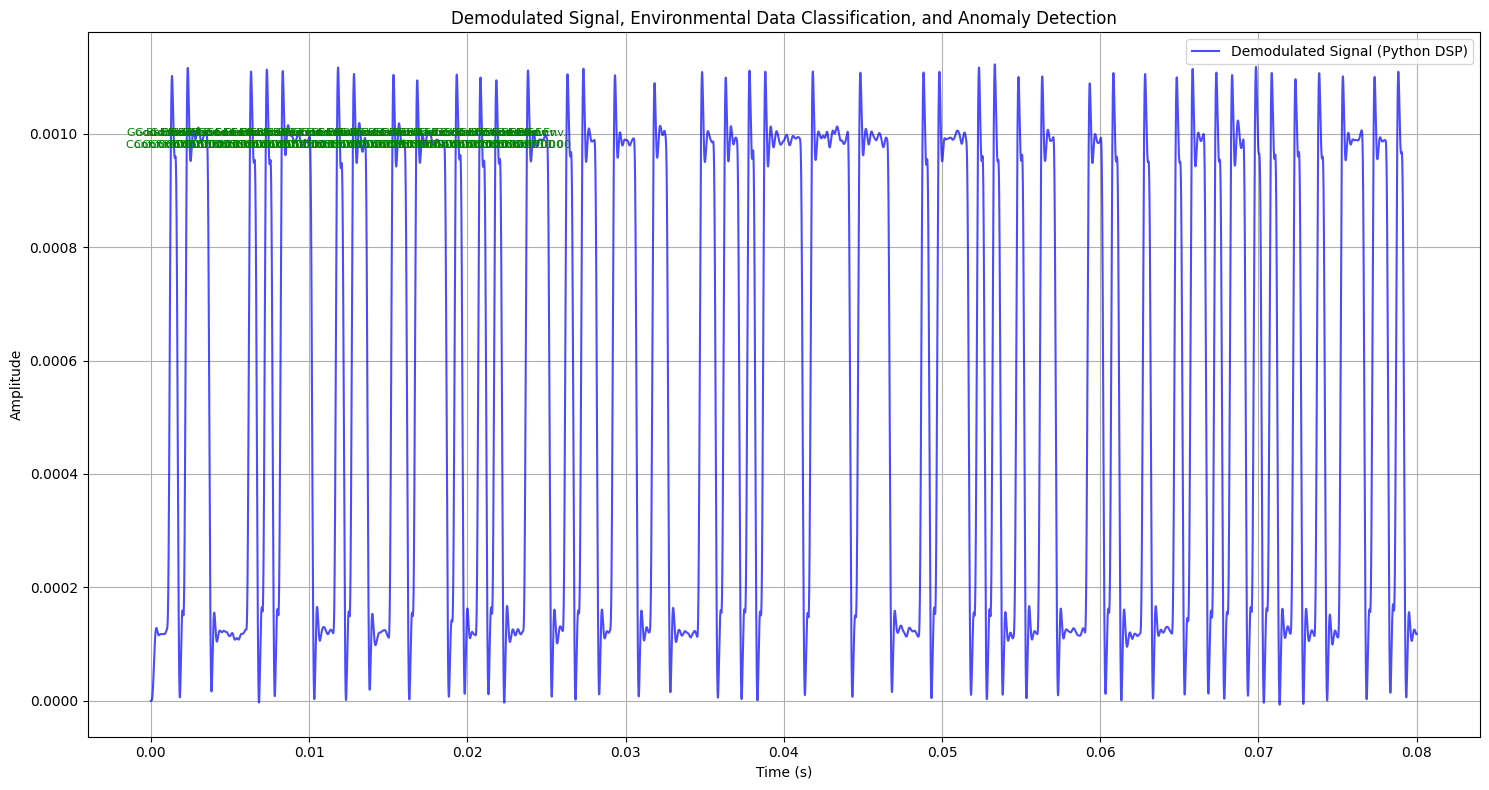

In [9]:
# --- Step 9: Load and Initialize TensorFlow Lite Models for Inference ---
print("\n--- Starting TFLite Inference ---")
interpreter_env = tf.lite.Interpreter(model_path=tflite_env_classifier_path)
interpreter_env.allocate_tensors()
input_details_env = interpreter_env.get_input_details()
output_details_env = interpreter_env.get_output_details()
print(f"Environmental data classifier model '{tflite_env_classifier_path}' loaded for inference.")

interpreter_anomaly = tf.lite.Interpreter(model_path=tflite_anomaly_detector_path)
interpreter_anomaly.allocate_tensors()
input_details_anomaly = interpreter_anomaly.get_input_details()
output_details_anomaly = interpreter_anomaly.get_output_details()
print(f"Anomaly detector model '{tflite_anomaly_detector_path}' loaded for inference.")

# --- Step 10: Process Signal Segments and Perform Inference ---
predicted_env_classes = []
env_confidences = []
anomaly_predictions = []
anomaly_scores = []
anomaly_explanations = []

num_segments_to_process = len(demodulated_signal) // samples_per_bit_duration

print(f"\nProcessing {num_segments_to_process} signal segments with Edge AI models...")
for i in range(num_segments_to_process):
    start_idx = i * samples_per_bit_duration
    end_idx = start_idx + samples_per_bit_duration
    segment = demodulated_signal[start_idx:end_idx]

    if len(segment) != samples_per_bit_duration:
        continue # Skip incomplete segments

    # Normalize segment for environmental data classifier
    segment_norm_env = (segment - env_model_mean) / env_model_std
    # Normalize segment for anomaly detector
    segment_norm_anomaly = (segment - anomaly_model_mean) / anomaly_model_std

    # Environmental Data Classification using TFLite
    predicted_class, env_confidence = decode_with_tflite_env_classifier(
        interpreter_env, input_details_env, output_details_env, segment_norm_env
    )
    predicted_env_classes.append(predicted_class)
    env_confidences.append(env_confidence)

    # Anomaly Detection using TFLite
    is_anomaly, anomaly_score = predict_anomaly_with_tflite(
        interpreter_anomaly, input_details_anomaly, output_details_anomaly, segment_norm_anomaly
    )
    anomaly_predictions.append(is_anomaly)
    anomaly_scores.append(anomaly_score)

    # Explainable AI for Anomalies
    if is_anomaly:
        explanation = explain_anomaly(segment, anomaly_model_mean, anomaly_model_std)
        anomaly_explanations.append(explanation)
    else:
        anomaly_explanations.append("") # Empty for non-anomalous

predicted_env_classes = np.array(predicted_env_classes)
env_confidences = np.array(env_confidences)
anomaly_predictions = np.array(anomaly_predictions)
anomaly_scores = np.array(anomaly_scores)

# --- Define human-readable class labels for output ---
class_labels = {0: "Good Env.", 1: "Bad Env."} # e.g., Water Quality: 0=Good, 1=Bad; Pathogens: 0=Low, 1=High

print(f"\nPredicted Environmental Classes (TFLite): {[class_labels[c] for c in predicted_env_classes[:20]]}...")
print(f"Confidences: {np.round(env_confidences[:20], 2)}...")
print(f"Anomaly Predictions: {anomaly_predictions.astype(int)[:20]}...")
print(f"Anomaly Scores: {np.round(anomaly_scores[:20], 2)}...")
print(f"Anomaly Explanations (first 5 anomalies):")
for i, expl in enumerate(anomaly_explanations):
    if expl and i < 5: # Show up to 5 explanations
        print(f"  Segment {i}: {expl}")

# --- Step 11: Verification and Visualization ---
true_classes_for_accuracy = original_encoded_bits[:len(predicted_env_classes)]
accuracy = calculate_accuracy(true_classes_for_accuracy, predicted_env_classes)
print(f"\n--- Results ---")
print(f"Environmental Data Classification Accuracy (TFLite Model): {accuracy:.4f}")

if accuracy == 1.0:
    print("Classification Verification: SUCCESS! All predicted classes match original data.")
else:
    print("Classification Verification: FAIL! Mismatched classes detected. Accuracy < 1.0.")


plt.figure(figsize=(15, 8))

# Downsample for visualization if signal is very large for performance
max_points = 50000
plot_step = 1
if len(demodulated_signal) > max_points:
    plot_step = int(len(demodulated_signal) / max_points)
    plot_signal = demodulated_signal[::plot_step]
    plot_time = t[::plot_step]
else:
    plot_signal = demodulated_signal
    plot_time = t

plt.plot(plot_time, plot_signal, label='Demodulated Signal (Python DSP)', alpha=0.7, color='blue')
plt.title('Demodulated Signal, Environmental Data Classification, and Anomaly Detection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Overlay predicted classes, confidence, anomaly status, and explanations
# Plot only for a subset of the signal to avoid clutter if too long
plot_segment_range = min(len(predicted_env_classes), 50) # Plot max 50 segments for clear visualization
for i in range(plot_segment_range):
    predicted_class = predicted_env_classes[i]
    segment_center_time = (i * samples_per_bit_duration + samples_per_bit_duration / 2) / fs

    # Color based on correctness (if original data is available)
    class_matches_original = (predicted_class == true_classes_for_accuracy[i])
    class_color = 'green' if class_matches_original else 'red'

    # Text for class and confidence
    plt.text(segment_center_time,
             np.max(demodulated_signal) * 0.9, # Place info higher
             f"{class_labels[predicted_class]}\nConf: {env_confidences[i]:.2f}",
             color=class_color,
             fontsize=8, ha='center', va='top')

    # Anomaly marker/text with explanation
    if anomaly_predictions[i]:
        plt.text(segment_center_time,
                 np.min(demodulated_signal) * 0.9,
                 f"Anomaly! ({np.round(anomaly_scores[i], 2)})\n{anomaly_explanations[i].split(':')[1].strip()}", # Extract just the explanation part
                 color='purple',
                 fontsize=7, ha='center', va='bottom',
                 bbox=dict(facecolor='yellow', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()